<a href="https://colab.research.google.com/github/quantwav/Lab4-dsff/blob/main/0326_0047_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook settings**



In [1]:
%matplotlib inline
# Use %matplotlib ipympl or %matplotlib widget if you want interactive matplotlib plots
#%matplotlib widget

# Shuts off Jedi to speed up tab completions
# the command %config Completer.use_jedi = False is used in IPython or Jupyter environments to disable the use of the Jedi library for autocompletion, which can sometimes lead to faster completion suggestions.
%config Completer.use_jedi = False

# reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
%autoreload 2

In [2]:
#mport ast refers to importing the ast module, which is a part of Python's standard library. The ast module provides facilities for processing, analyzing, and modifying Abstract Syntax Trees (ASTs).
import ast
import datetime
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import plotly.express as px
import seaborn as sns
import scipy.stats as ss
#The primary use of the tqdm function is to wrap around any iterable, like a list or a loop, to display a smart progress meter.
#For example, if you have a for loop that iterates over a large dataset, you can wrap tqdm around the iterable, and it will display a progress bar that updates with each iteration.
from tqdm import tqdm

!pip install itables
# To display dataframes as interactive tables in the notebook:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [3]:
# https://drive.google.com/file/d/1_YKlTeSfB2L67Db3PV9-kQX181njABvj/view?usp=drive_link

if not os.path.exists("20-diamonds.pq"):
    !gdown --id 1_YKlTeSfB2L67Db3PV9-kQX181njABvj

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_YKlTeSfB2L67Db3PV9-kQX181njABvj
To: /content/20-diamonds.pq
100% 590k/590k [00:00<00:00, 6.62MB/s]


# **Read, verify and clean**

In [4]:
np.seterr(divide='ignore')
pd.options.display.max_colwidth = 150

TOL = 1.0e-12
SEED = 24

In [5]:
df = pd.read_parquet('20-diamonds.pq')
df


dshape        cut color clarity deliv_date     price  carat
0       Emerald  Very Good     J     SI2        NaT     112.0   0.30
1       Emerald       Good     K     SI1        NaT     212.0   0.30
2       Emerald  Very Good     J     SI1        NaT     215.0   0.30
3       Emerald  Very Good     I     SI2        NaT     215.0   0.30
4       Emerald  Very Good     K     VS2        NaT     215.0   0.30
...         ...        ...   ...     ...        ...       ...    ...
131109     Oval  Very Good     E      FL 2021-08-17  548774.0   8.28
131110  Emerald  Very Good     D      FL 2021-08-03  562401.0   7.00
131111    Round      Ideal     D    VVS2 2021-08-02  577753.0   8.10
131112  Emerald  Very Good     D      FL 2021-08-02  717968.0   8.16
131113    Round      Ideal     D      FL 2021-08-17  821831.0   7.81

[131114 rows x 7 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131114 entries, 0 to 131113
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   dshape      131114 non-null  object        
 1   cut         131114 non-null  object        
 2   color       131114 non-null  object        
 3   clarity     131114 non-null  object        
 4   deliv_date  129479 non-null  datetime64[ns]
 5   price       131114 non-null  float64       
 6   carat       131114 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 7.0+ MB


In [7]:
df = (
    df
    .rename(columns={'dshape':'c_shape', 'color':'c_color'})
    .assign(c_shape=lambda x: x.c_shape.astype('category')
           )
    .assign(c_color=lambda x: x.c_color.astype('category')
           )
    .drop(columns= ['deliv_date'])
)
df.info()
df.c_shape.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131114 entries, 0 to 131113
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   c_shape  131114 non-null  category
 1   cut      131114 non-null  object  
 2   c_color  131114 non-null  category
 3   clarity  131114 non-null  object  
 4   price    131114 non-null  float64 
 5   carat    131114 non-null  float64 
dtypes: category(2), float64(2), object(2)
memory usage: 4.3+ MB


Round       82450
Oval        11526
Emerald     10404
Princess     8017
Cushion      7218
Pear         5426
Radiant      1913
Heart        1611
Marquise     1453
Asscher      1096
Name: c_shape, dtype: int64

In [8]:
clarity_order = {
    'FL': 11,   # Flawless
    'IF': 10,   # Internally Flawless
    'VVS1': 9,  # Very, Very Slightly Included (level 1)
    'VVS2': 8,  # Very, Very Slightly Included (level 2)
    'VS1': 7,   # Very Slightly Included (level 1)
    'VS2': 6,   # Very Slightly Included (level 2)
    'SI1': 5,   # Slightly Included (level 1)
    'SI2': 4,   # Slightly Included (level 2)
    'I1': 3,    # Included (level 1)
    'I2': 2,    # Included (level 2)
    'I3': 1     # Included (level 3)
}

df['clarity_encoded'] = df['clarity'].map(clarity_order)

df = df.drop(columns = ['clarity'])

df

c_shape        cut c_color     price  carat  clarity_encoded
0       Emerald  Very Good       J     112.0   0.30                4
1       Emerald       Good       K     212.0   0.30                5
2       Emerald  Very Good       J     215.0   0.30                5
3       Emerald  Very Good       I     215.0   0.30                4
4       Emerald  Very Good       K     215.0   0.30                6
...         ...        ...     ...       ...    ...              ...
131109     Oval  Very Good       E  548774.0   8.28               11
131110  Emerald  Very Good       D  562401.0   7.00               11
131111    Round      Ideal       D  577753.0   8.10                8
131112  Emerald  Very Good       D  717968.0   8.16               11
131113    Round      Ideal       D  821831.0   7.81               11

[131114 rows x 6 columns]

In [9]:
df.cut.value_counts()

Ideal          62806
Very Good      55538
Good           12045
Astor Ideal      725
Name: cut, dtype: int64

In [10]:
cut_order = {
    'Astor Ideal': 4,
    'Ideal': 3,
    'Very Good': 2,
    'Good': 1
}


df['cut_encoded'] = df['cut'].map(cut_order)

df = df.drop( columns= 'cut')

df

c_shape c_color     price  carat  clarity_encoded  cut_encoded
0       Emerald       J     112.0   0.30                4            2
1       Emerald       K     212.0   0.30                5            1
2       Emerald       J     215.0   0.30                5            2
3       Emerald       I     215.0   0.30                4            2
4       Emerald       K     215.0   0.30                6            2
...         ...     ...       ...    ...              ...          ...
131109     Oval       E  548774.0   8.28               11            2
131110  Emerald       D  562401.0   7.00               11            2
131111    Round       D  577753.0   8.10                8            3
131112  Emerald       D  717968.0   8.16               11            2
131113    Round       D  821831.0   7.81               11            3

[131114 rows x 6 columns]

In [11]:
clist = [v for v in df.columns if v.startswith('c_')]
for c in clist:
    d = pd.get_dummies(df[c],'i_'+c,drop_first=True)
    df = pd.concat((df,d),axis=1)

df

c_shape c_color     price  carat  clarity_encoded  cut_encoded  \
0       Emerald       J     112.0   0.30                4            2   
1       Emerald       K     212.0   0.30                5            1   
2       Emerald       J     215.0   0.30                5            2   
3       Emerald       I     215.0   0.30                4            2   
4       Emerald       K     215.0   0.30                6            2   
...         ...     ...       ...    ...              ...          ...   
131109     Oval       E  548774.0   8.28               11            2   
131110  Emerald       D  562401.0   7.00               11            2   
131111    Round       D  577753.0   8.10                8            3   
131112  Emerald       D  717968.0   8.16               11            2   
131113    Round       D  821831.0   7.81               11            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
0                       0                  1                0   
1                       0                  1                0   
2                       0                  1                0   
3                       0                  1                0   
4                       0                  1                0   
...                   ...                ...              ...   
131109                  0                  0                0   
131110                  0                  1                0   
131111                  0                  0                0   
131112                  0                  1                0   
131113                  0                  0                0   

        i_c_shape_Marquise  ...  i_c_shape_Princess  i_c_shape_Radiant  \
0                        0  ...                   0                  0   
1                        0  ...                   0                  0   
2                        0  ...                   0                  0   
3                        0  ...                   0                  0   
4                        0  ...                   0                  0   
...                    ...  ...                 ...                ...   
131109                   0  ...                   0                  0   
131110                   0  ...                   0                  0   
131111                   0  ...                   0                  0   
131112                   0  ...                   0                  0   
131113                   0  ...                   0                  0   

        i_c_shape_Round  i_c_color_E  i_c_color_F  i_c_color_G  i_c_color_H  \
0                     0            0            0            0            0   
1                     0            0            0            0            0   
2                     0            0            0            0            0   
3                     0            0            0            0            0   
4                     0            0            0            0            0   
...                 ...          ...          ...          ...          ...   
131109                0            1            0            0            0   
131110                0            0            0            0            0   
131111                1            0            0            0            0   
131112                0            0            0            0            0   
131113                1            0            0            0            0   

        i_c_color_I  i_c_color_J  i_c_color_K  
0                 0            1            0  
1                 0            0            1  
2                 0            1            0  
3                 1            0            0  
4                 0            0            1  
...             ...          ...          ...  
131109            0            0            0  
131110            0            0            0  
131111            0            0            0  
131112            0 

In [12]:
vlist = ['price','carat']
for v in vlist:
    if v != 'price':
        df[v] = np.where(df[v]<0,np.NaN,df[v])
    else:
        df[v] = np.where(df[v]<=0,np.NaN,df[v])

In [13]:
for v in vlist:
    if v in ['price']:
        df['l_'+v] = np.log(df[v])
    else:
        df['l_'+v] = np.log(1+df[v])

df

c_shape c_color     price  carat  clarity_encoded  cut_encoded  \
0       Emerald       J     112.0   0.30                4            2   
1       Emerald       K     212.0   0.30                5            1   
2       Emerald       J     215.0   0.30                5            2   
3       Emerald       I     215.0   0.30                4            2   
4       Emerald       K     215.0   0.30                6            2   
...         ...     ...       ...    ...              ...          ...   
131109     Oval       E  548774.0   8.28               11            2   
131110  Emerald       D  562401.0   7.00               11            2   
131111    Round       D  577753.0   8.10                8            3   
131112  Emerald       D  717968.0   8.16               11            2   
131113    Round       D  821831.0   7.81               11            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
0                       0                  1                0   
1                       0                  1                0   
2                       0                  1                0   
3                       0                  1                0   
4                       0                  1                0   
...                   ...                ...              ...   
131109                  0                  0                0   
131110                  0                  1                0   
131111                  0                  0                0   
131112                  0                  1                0   
131113                  0                  0                0   

        i_c_shape_Marquise  ...  i_c_shape_Round  i_c_color_E  i_c_color_F  \
0                        0  ...                0            0            0   
1                        0  ...                0            0            0   
2                        0  ...                0            0            0   
3                        0  ...                0            0            0   
4                        0  ...                0            0            0   
...                    ...  ...              ...          ...          ...   
131109                   0  ...                0            1            0   
131110                   0  ...                0            0            0   
131111                   0  ...                1            0            0   
131112                   0  ...                0            0            0   
131113                   0  ...                1            0            0   

        i_c_color_G  i_c_color_H  i_c_color_I  i_c_color_J  i_c_color_K  \
0                 0            0            0            1            0   
1                 0            0            0            0            1   
2                 0            0            0            1            0   
3                 0            0            1            0            0   
4                 0            0            0            0            1   
...             ...          ...          ...          ...          ...   
131109            0            0            0            0            0   
131110            0            0            0            0            0   
131111            0            0            0            0            0   
131112            0            0            0            0            0   
131113            0            0            0            0            0   

          l_price   l_carat  
0        4.718499  0.262364  
1        5.356586  0.262364  
2        5.370638  0.262364  
3        5.370638  0.262364  
4        5.370638  0.262364  
...           ...       ...  
131109  13.215442  2.227862  
131110  13.239970  2.079442  
131111  13.266902  2.208274  
131112  13.484180  2.214846  
131113  13.619290  2.175887  

[131114 rows x 24 columns]

In [14]:
df['const'] = 1

**Final Check**

In [15]:
assert df.isna().sum().sum() == 0

numeric = df.dtypes.loc[lambda x: (x != 'object') & (x != 'category') & (x.index != 'const')].index
assert (df[numeric].std(axis=0) > TOL).all()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131114 entries, 0 to 131113
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   c_shape             131114 non-null  category
 1   c_color             131114 non-null  category
 2   price               131114 non-null  float64 
 3   carat               131114 non-null  float64 
 4   clarity_encoded     131114 non-null  int64   
 5   cut_encoded         131114 non-null  int64   
 6   i_c_shape_Cushion   131114 non-null  uint8   
 7   i_c_shape_Emerald   131114 non-null  uint8   
 8   i_c_shape_Heart     131114 non-null  uint8   
 9   i_c_shape_Marquise  131114 non-null  uint8   
 10  i_c_shape_Oval      131114 non-null  uint8   
 11  i_c_shape_Pear      131114 non-null  uint8   
 12  i_c_shape_Princess  131114 non-null  uint8   
 13  i_c_shape_Radiant   131114 non-null  uint8   
 14  i_c_shape_Round     131114 non-null  uint8   
 15  i_c_color_E      

In [17]:
df

c_shape c_color     price  carat  clarity_encoded  cut_encoded  \
0       Emerald       J     112.0   0.30                4            2   
1       Emerald       K     212.0   0.30                5            1   
2       Emerald       J     215.0   0.30                5            2   
3       Emerald       I     215.0   0.30                4            2   
4       Emerald       K     215.0   0.30                6            2   
...         ...     ...       ...    ...              ...          ...   
131109     Oval       E  548774.0   8.28               11            2   
131110  Emerald       D  562401.0   7.00               11            2   
131111    Round       D  577753.0   8.10                8            3   
131112  Emerald       D  717968.0   8.16               11            2   
131113    Round       D  821831.0   7.81               11            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
0                       0                  1                0   
1                       0                  1                0   
2                       0                  1                0   
3                       0                  1                0   
4                       0                  1                0   
...                   ...                ...              ...   
131109                  0                  0                0   
131110                  0                  1                0   
131111                  0                  0                0   
131112                  0                  1                0   
131113                  0                  0                0   

        i_c_shape_Marquise  ...  i_c_color_E  i_c_color_F  i_c_color_G  \
0                        0  ...            0            0            0   
1                        0  ...            0            0            0   
2                        0  ...            0            0            0   
3                        0  ...            0            0            0   
4                        0  ...            0            0            0   
...                    ...  ...          ...          ...          ...   
131109                   0  ...            1            0            0   
131110                   0  ...            0            0            0   
131111                   0  ...            0            0            0   
131112                   0  ...            0            0            0   
131113                   0  ...            0            0            0   

        i_c_color_H  i_c_color_I  i_c_color_J  i_c_color_K    l_price  \
0                 0            0            1            0   4.718499   
1                 0            0            0            1   5.356586   
2                 0            0            1            0   5.370638   
3                 0            1            0            0   5.370638   
4                 0            0            0            1   5.370638   
...             ...          ...          ...          ...        ...   
131109            0            0            0            0  13.215442   
131110            0            0            0            0  13.239970   
131111            0            0            0            0  13.266902   
131112            0            0            0            0  13.484180   
131113            0            0            0            0  13.619290   

         l_carat  const  
0       0.262364      1  
1       0.262364      1  
2       0.262364      1  
3       0.262364      1  
4       0.262364      1  
...          ...    ...  
131109  2.227862      1  
131110  2.079442      1  
131111  2.208274      1  
131112  2.214846      1  
131113  2.175887      1  

[131114 rows x 25 columns]

# **Train-test split**

In [18]:
train_size = 0.75
df_train = df.sample(frac=train_size,random_state=SEED)
train_idx = df_train.index
df_test = df.loc[~(df.index.isin(train_idx))]

assert set(df_test.index) & set(train_idx) == set()
assert set(df_test.index) | set(train_idx) == set(df.index)
assert (df_test.columns == df_train.columns).all()

In [19]:
cat_list = [c for c in df.columns if c.startswith('c_') ]
num_list = [c for c in df.columns if (c not in cat_list) & ~(c.startswith('i_')) & (c != 'const')]

num_list

df[num_list].dtypes

#Check Data Types: Ensure that the columns in df, df_train, and df_test referred to by num_list contain numeric data.
df[num_list].dtypes
df_train[num_list].dtypes
df_test[num_list].dtypes

price              float64
carat              float64
clarity_encoded      int64
cut_encoded          int64
l_price            float64
l_carat            float64
dtype: object

**Sample mean equality**

In [20]:
mu=df[num_list].mean()
se=df[num_list].std()/np.sqrt(len(df))

mu_train=df_train[num_list].mean()
se_train=df_train[num_list].std()/np.sqrt(len(df_train))

mu_test=df_test[num_list].mean()
se_test=df_test[num_list].std()/np.sqrt(len(df_test))

t_train=(mu - mu_train) / np.sqrt(se**2 + se_train**2)
t_test=(mu - mu_test) / np.sqrt(se**2 + se_test**2)

x = pd.concat((mu,mu_train,mu_test,t_train,t_test),
          axis=1,
          keys=['avg-full','avg-train','avg-test','t_train','t_test']
         )

# test for significance
assert (x.t_train < 1.65).all()
assert (x.t_test < 1.65).all()

x.style.format("{:.2f}")

,avg-full,avg-train,avg-test,t_train,t_test
price,6414.02,6419.26,6398.32,-0.08,0.16
carat,0.85,0.85,0.86,0.37,-0.75
clarity_encoded,6.48,6.48,6.47,-0.31,0.64
cut_encoded,2.40,2.40,2.39,-0.49,1.01
l_price,7.79,7.79,7.80,0.43,-0.88
l_carat,0.57,0.57,0.57,0.54,-1.10


**Categorical variables**

In [21]:
c = 'c_color'

eperc=df[c].value_counts(normalize=True)

# train test

etrain=(eperc*df_train.shape[0]).sort_index()

atrain=df_train[c].value_counts().sort_index()

chi2train=ss.chisquare(f_obs=atrain,f_exp=etrain)

# test test

etest=(eperc*df_test.shape[0]).sort_index()

atest=df_test[c].value_counts().sort_index()

chi2test=ss.chisquare(f_obs=atest,f_exp=etest)

#    A higher p-value suggests no significant difference.
print(f"Train Chi2 = {chi2train.pvalue:.2%}\nTest Chi2 = {chi2test.pvalue:.2%}")

Train Chi2 = 98.56%
Test Chi2 = 75.66%


Chi2 p-values in parentheses
   index   c_color          key
0      D  0.166458         Full
1      E  0.158900         Full
2      F  0.156726         Full
3      G  0.149420         Full
4      H  0.122222         Full
5      I  0.110385         Full
6      J  0.089197         Full
7      K  0.046692         Full
8      D  0.165931  Train (99%)
9      E  0.159077  Train (99%)
10     F  0.157643  Train (99%)
11     G  0.149599  Train (99%)
12     H  0.122285  Train (99%)
13     I  0.110346  Train (99%)
14     J  0.088960  Train (99%)
15     K  0.046158  Train (99%)
16     D  0.168040   Test (76%)
17     E  0.158368   Test (76%)
18     F  0.153975   Test (76%)
19     G  0.148880   Test (76%)
20     H  0.122033   Test (76%)
21     I  0.110501   Test (76%)
22     J  0.089908   Test (76%)
23     K  0.048295   Test (76%)
['c_shape', 'c_color']


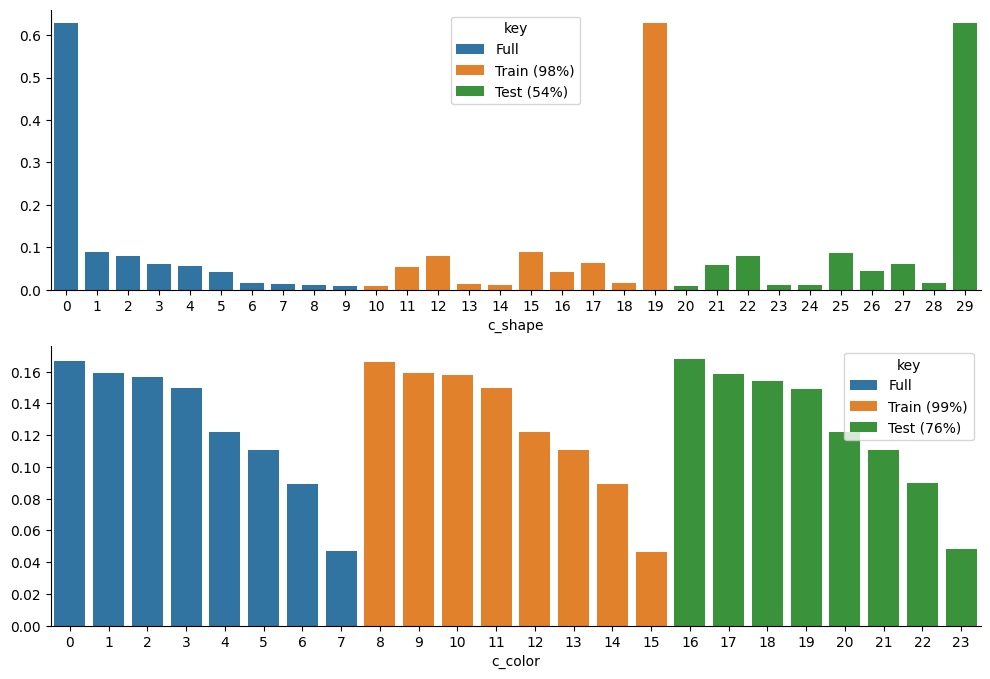

In [22]:

fig,axes=plt.subplots(len(cat_list),1,figsize=(12,len(cat_list)*4))
axes=np.ravel(axes)


for c,ax in zip(cat_list,axes):
    eperc=df[c].value_counts(normalize=True)

    # train test
    etrain=(eperc*df_train.shape[0]).sort_index()
    atrain=df_train[c].value_counts().sort_index()
    chi2train=ss.chisquare(f_obs=atrain,f_exp=etrain)

    # test test
    etest=(eperc*df_test.shape[0]).sort_index()
    atest=df_test[c].value_counts().sort_index()
    chi2test=ss.chisquare(f_obs=atest,f_exp=etest)

    eperc=eperc.to_frame().assign(key='Full')
    trainperc=(atrain/atrain.sum()).to_frame().assign(key=f'Train ({chi2train.pvalue:.0%})')
    testperc=(atest/atest.sum()).to_frame().assign(key=f'Test ({chi2test.pvalue:.0%})')
    z = pd.concat((eperc,trainperc,testperc),axis=0).reset_index()

    #print(z.index)
    sns.barplot(x=z.index, y=c, hue='key', data=z,ax=ax)
    ax.set_xlabel(c)
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

print("Chi2 p-values in parentheses")
print(z)
print(cat_list)

In [24]:
df_train.reset_index(drop=True).to_parquet('Diamond-wrangling-split-train.pq')
df_test.reset_index(drop=True).to_parquet('Diamond-wrangling-split-test.pq')

kvars = [
    'c_shape', 'c_color', 'price', 'carat', 'clarity_encoded', 'cut_encoded'
]
df[kvars].reset_index(drop=True).to_parquet('Diamond-wrangling-split.pq')

## **Lasso Regression**

In [43]:
df_train.head()

c_shape c_color    price  carat  clarity_encoded  cut_encoded  \
121757     Round       H  18236.0   1.92                5            3   
53521      Round       J   1645.0   0.60                8            3   
45450      Round       G   1240.0   0.45                7            3   
20269   Marquise       E    533.0   0.33                5            2   
51153      Round       G   1529.0   0.50                4            3   

        i_c_shape_Cushion  i_c_shape_Emerald  i_c_shape_Heart  \
121757                  0                  0                0   
53521                   0                  0                0   
45450                   0                  0                0   
20269                   0                  0                0   
51153                   0                  0                0   

        i_c_shape_Marquise  ...  i_c_color_E  i_c_color_F  i_c_color_G  \
121757                   0  ...            0            0            0   
53521                    0  ...            0            0            0   
45450                    0  ...            0            0            1   
20269                    1  ...            1            0            0   
51153                    0  ...            0            0            1   

        i_c_color_H  i_c_color_I  i_c_color_J  i_c_color_K   l_price  \
121757            1            0            0            0  9.811153   
53521             0            0            1            0  7.405496   
45450             0            0            0            0  7.122867   
20269             0            0            0            0  6.278521   
51153             0            0            0            0  7.332369   

         l_carat  const  
121757  1.071584      1  
53521   0.470004      1  
45450   0.371564      1  
20269   0.285179      1  
51153   0.405465      1  

[5 rows x 25 columns]

In [44]:
import multiprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Define the Lasso model
lr = Lasso()
folds = 3
CPUS = multiprocessing.cpu_count()
X_train = df_train.drop(columns=['price','c_shape','c_color'])  # Features
Y_train = df_train['price']  # Target variable

# Evaluate the model using cross-validation
lr_cv = cross_val_score(lr,
                        X_train,
                        Y_train,
                        cv=folds,
                        scoring='r2',
                        n_jobs=CPUS-1
                       )
# Print default parameters
print(f"Default parameters:\n{lr.get_params()}")

# Print fold scores
print(f"Fold scores:\n{lr_cv}")

# Print mean score
print(f"Mean score: {lr_cv.mean():.8f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.809e+09, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.408e+09, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


Default parameters:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Fold scores:
[0.84149851 0.83224497 0.78841987]
Mean score: 0.82072112


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+09, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


In [48]:
from sklearn.model_selection import GridSearchCV
from time import time
def timer_func(func):
   def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        t = str(datetime.timedelta(seconds=t2-t1))
        print(f'Function {func.__name__!r} executed in {t}')
        return result
   return wrap_func

alphas = np.logspace(start=-5,stop=-0.5,num=20,base=10.0)

# Define a function to perform grid search with Lasso regression
@timer_func
def lasso_gs(alphas):
    # Define the parameter grid
    tuned_params = {'alpha': alphas}

    # Perform grid search
    lr_gs = GridSearchCV(lr,
                         param_grid=tuned_params,
                         cv=folds,
                         refit=False,
                         n_jobs=CPUS-1,
                         verbose=10,
                        ).fit(X_train, y_train)

    return lr_gs

# Perform grid search with the defined alphas
lr_gs = lasso_gs(alphas)

# Print the grid search results
print(lr_gs)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START alpha=1e-05................................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 1/20] END .................alpha=1e-05;, score=0.841 total time=   1.9s
[CV 2/3; 1/20] START alpha=1e-05................................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 1/20] END .................alpha=1e-05;, score=0.832 total time=   2.0s
[CV 3/3; 1/20] START alpha=1e-05................................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 1/20] END .................alpha=1e-05;, score=0.789 total time=   1.9s
[CV 1/3; 2/20] START alpha=1.725210549942039e-05................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 2/20] END .alpha=1.725210549942039e-05;, score=0.841 total time=   2.5s
[CV 2/3; 2/20] START alpha=1.725210549942039e-05................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 2/20] END .alpha=1.725210549942039e-05;, score=0.832 total time=   2.8s
[CV 3/3; 2/20] START alpha=1.725210549942039e-05................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 2/20] END .alpha=1.725210549942039e-05;, score=0.789 total time=   1.9s
[CV 1/3; 3/20] START alpha=2.9763514416313192e-05...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 3/20] END alpha=2.9763514416313192e-05;, score=0.841 total time=   1.9s
[CV 2/3; 3/20] START alpha=2.9763514416313192e-05...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 3/20] END alpha=2.9763514416313192e-05;, score=0.832 total time=   1.9s
[CV 3/3; 3/20] START alpha=2.9763514416313192e-05...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 3/20] END alpha=2.9763514416313192e-05;, score=0.789 total time=   1.9s
[CV 1/3; 4/20] START alpha=5.1348329074375493e-05...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 4/20] END alpha=5.1348329074375493e-05;, score=0.841 total time=   2.6s
[CV 2/3; 4/20] START alpha=5.1348329074375493e-05...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 4/20] END alpha=5.1348329074375493e-05;, score=0.832 total time=   2.8s
[CV 3/3; 4/20] START alpha=5.1348329074375493e-05...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 4/20] END alpha=5.1348329074375493e-05;, score=0.789 total time=   1.9s
[CV 1/3; 5/20] START alpha=8.858667904100833e-05................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 5/20] END .alpha=8.858667904100833e-05;, score=0.841 total time=   2.7s
[CV 2/3; 5/20] START alpha=8.858667904100833e-05................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 5/20] END .alpha=8.858667904100833e-05;, score=0.832 total time=   1.9s
[CV 3/3; 5/20] START alpha=8.858667904100833e-05................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 5/20] END .alpha=8.858667904100833e-05;, score=0.789 total time=   1.9s
[CV 1/3; 6/20] START alpha=0.00015283067326587687...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 6/20] END alpha=0.00015283067326587687;, score=0.841 total time=   3.6s
[CV 2/3; 6/20] START alpha=0.00015283067326587687...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 6/20] END alpha=0.00015283067326587687;, score=0.832 total time=   1.9s
[CV 3/3; 6/20] START alpha=0.00015283067326587687...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 6/20] END alpha=0.00015283067326587687;, score=0.789 total time=   2.7s
[CV 1/3; 7/20] START alpha=0.00026366508987303583...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 7/20] END alpha=0.00026366508987303583;, score=0.841 total time=   5.6s
[CV 2/3; 7/20] START alpha=0.00026366508987303583...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 7/20] END alpha=0.00026366508987303583;, score=0.832 total time=   3.7s
[CV 3/3; 7/20] START alpha=0.00026366508987303583...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 7/20] END alpha=0.00026366508987303583;, score=0.789 total time=   1.9s
[CV 1/3; 8/20] START alpha=0.00045487779470037773...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 8/20] END alpha=0.00045487779470037773;, score=0.841 total time=   4.0s
[CV 2/3; 8/20] START alpha=0.00045487779470037773...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 8/20] END alpha=0.00045487779470037773;, score=0.832 total time=   2.2s
[CV 3/3; 8/20] START alpha=0.00045487779470037773...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 8/20] END alpha=0.00045487779470037773;, score=0.789 total time=   4.2s
[CV 1/3; 9/20] START alpha=0.0007847599703514606................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 9/20] END .alpha=0.0007847599703514606;, score=0.841 total time=   1.9s
[CV 2/3; 9/20] START alpha=0.0007847599703514606................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 9/20] END .alpha=0.0007847599703514606;, score=0.832 total time=   1.9s
[CV 3/3; 9/20] START alpha=0.0007847599703514606................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.206e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 9/20] END .alpha=0.0007847599703514606;, score=0.789 total time=   1.9s
[CV 1/3; 10/20] START alpha=0.0013538761800225433...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 10/20] END alpha=0.0013538761800225433;, score=0.841 total time=   1.9s
[CV 2/3; 10/20] START alpha=0.0013538761800225433...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 10/20] END alpha=0.0013538761800225433;, score=0.832 total time=   2.5s
[CV 3/3; 10/20] START alpha=0.0013538761800225433...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 10/20] END alpha=0.0013538761800225433;, score=0.789 total time=   3.8s
[CV 1/3; 11/20] START alpha=0.002335721469090121................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 11/20] END .alpha=0.002335721469090121;, score=0.841 total time=   2.0s
[CV 2/3; 11/20] START alpha=0.002335721469090121................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 11/20] END .alpha=0.002335721469090121;, score=0.832 total time=   2.0s
[CV 3/3; 11/20] START alpha=0.002335721469090121................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 11/20] END .alpha=0.002335721469090121;, score=0.789 total time=   1.9s
[CV 1/3; 12/20] START alpha=0.0040296113202004..................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 12/20] END ...alpha=0.0040296113202004;, score=0.841 total time=   1.9s
[CV 2/3; 12/20] START alpha=0.0040296113202004..................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 12/20] END ...alpha=0.0040296113202004;, score=0.832 total time=   3.7s
[CV 3/3; 12/20] START alpha=0.0040296113202004..................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+12, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 12/20] END ...alpha=0.0040296113202004;, score=0.789 total time=   2.8s
[CV 1/3; 13/20] START alpha=0.0069519279617756054...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 13/20] END alpha=0.0069519279617756054;, score=0.841 total time=   3.0s
[CV 2/3; 13/20] START alpha=0.0069519279617756054...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 13/20] END alpha=0.0069519279617756054;, score=0.832 total time=   1.9s
[CV 3/3; 13/20] START alpha=0.0069519279617756054...............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.776e+11, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 13/20] END alpha=0.0069519279617756054;, score=0.789 total time=   1.9s
[CV 1/3; 14/20] START alpha=0.011993539462092343................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+12, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 14/20] END .alpha=0.011993539462092343;, score=0.841 total time=   3.7s
[CV 2/3; 14/20] START alpha=0.011993539462092343................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+12, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 14/20] END .alpha=0.011993539462092343;, score=0.832 total time=   2.0s
[CV 3/3; 14/20] START alpha=0.011993539462092343................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.355e+11, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 14/20] END .alpha=0.011993539462092343;, score=0.789 total time=   1.9s
[CV 1/3; 15/20] START alpha=0.02069138081114788.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.902e+11, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 15/20] END ..alpha=0.02069138081114788;, score=0.841 total time=   2.9s
[CV 2/3; 15/20] START alpha=0.02069138081114788.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.485e+11, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 15/20] END ..alpha=0.02069138081114788;, score=0.832 total time=   5.0s
[CV 3/3; 15/20] START alpha=0.02069138081114788.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.537e+11, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 15/20] END ..alpha=0.02069138081114788;, score=0.789 total time=   2.3s
[CV 1/3; 16/20] START alpha=0.035696988468260624................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.257e+11, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 16/20] END .alpha=0.035696988468260624;, score=0.841 total time=   1.9s
[CV 2/3; 16/20] START alpha=0.035696988468260624................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.945e+11, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 16/20] END .alpha=0.035696988468260624;, score=0.832 total time=   1.9s
[CV 3/3; 16/20] START alpha=0.035696988468260624................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.543e+11, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 16/20] END .alpha=0.035696988468260624;, score=0.789 total time=   1.9s
[CV 1/3; 17/20] START alpha=0.06158482110660261.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.816e+11, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 17/20] END ..alpha=0.06158482110660261;, score=0.841 total time=   1.9s
[CV 2/3; 17/20] START alpha=0.06158482110660261.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+11, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 17/20] END ..alpha=0.06158482110660261;, score=0.832 total time=   3.1s
[CV 3/3; 17/20] START alpha=0.06158482110660261.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e+11, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 17/20] END ..alpha=0.06158482110660261;, score=0.789 total time=   2.3s
[CV 1/3; 18/20] START alpha=0.10624678308940409.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+11, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 18/20] END ..alpha=0.10624678308940409;, score=0.841 total time=   1.9s
[CV 2/3; 18/20] START alpha=0.10624678308940409.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+11, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 18/20] END ..alpha=0.10624678308940409;, score=0.832 total time=   1.9s
[CV 3/3; 18/20] START alpha=0.10624678308940409.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+11, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 18/20] END ..alpha=0.10624678308940409;, score=0.789 total time=   1.9s
[CV 1/3; 19/20] START alpha=0.18329807108324336.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.881e+10, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 19/20] END ..alpha=0.18329807108324336;, score=0.841 total time=   1.9s
[CV 2/3; 19/20] START alpha=0.18329807108324336.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.647e+10, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 19/20] END ..alpha=0.18329807108324336;, score=0.832 total time=   3.2s
[CV 3/3; 19/20] START alpha=0.18329807108324336.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.418e+10, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 19/20] END ..alpha=0.18329807108324336;, score=0.789 total time=   2.2s
[CV 1/3; 20/20] START alpha=0.31622776601683794.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.712e+10, tolerance: 1.734e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 20/20] END ..alpha=0.31622776601683794;, score=0.841 total time=   1.9s
[CV 2/3; 20/20] START alpha=0.31622776601683794.................................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.516e+10, tolerance: 1.698e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 20/20] END ..alpha=0.31622776601683794;, score=0.832 total time=   2.0s
[CV 3/3; 20/20] START alpha=0.31622776601683794.................................
[CV 3/3; 20/20] END ..alpha=0.31622776601683794;, score=0.789 total time=   1.9s
Function 'lasso_gs' executed in 0:02:26.831410
GridSearchCV(cv=3, estimator=Lasso(), n_jobs=1,
             param_grid={'alpha': array([1.00000000e-05, 1.72521055e-05, 2.97635144e-05, 5.13483291e-05,
       8.85866790e-05, 1.52830673e-04, 2.63665090e-04, 4.54877795e-04,
       7.84759970e-04, 1.35387618e-03, 2.33572147e-03, 4.02961132e-03,
       6.95192796e-03, 1.19935395e-02, 2.06913808e-02, 3.56969885e-02,
       6.15848211e-02, 1.06246783e-01, 1.83298071e-01, 3.16227766e-01])},
             refit=False, verbose=10)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.579e+10, tolerance: 1.532e+09
  model = cd_fast.enet_coordinate_descent(


In [49]:
print(f"Best parameter: {lr_gs.best_params_['alpha']:.4f} and score {lr_gs.best_score_:.2%}")

Best parameter: 0.3162 and score 82.07%


In [50]:
# Score (i.e., R-squared) for each alpha
scores = lr_gs.cv_results_['mean_test_score']
# SD of the R-squared for each alpha
scores_sd = lr_gs.cv_results_['std_test_score']
# Standard error of the R-squared for each alpha
std_error = scores_sd / np.sqrt(folds)

cv_results = lr_gs.cv_results_
tempcvresults=pd.DataFrame(cv_results)
print(tempcvresults)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        1.905113      0.039514         0.006931        0.002802     0.00001   
1        2.406330      0.390080         0.006415        0.001922    0.000017   
2        1.883547      0.017280         0.006500        0.001888     0.00003   
3        2.418512      0.382033         0.011905        0.006423    0.000051   
4        2.151477      0.365902         0.007728        0.001988    0.000089   
5        2.743823      0.678876         0.008171        0.002026    0.000153   
6        3.702069      1.493387         0.016179        0.009950    0.000264   
7        3.443407      0.922436         0.009294        0.000266    0.000455   
8        1.895189      0.034627         0.009473        0.003706    0.000785   
9        2.706931      0.773096         0.006473        0.001863    0.001354   
10       1.946452      0.036010         0.006428        0.001849    0.002336   
11       2.799064      0.742015         

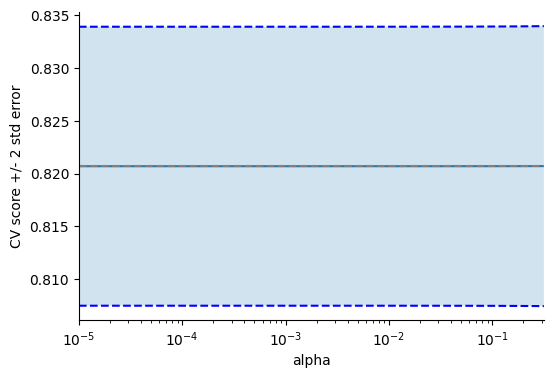

In [51]:
# Plotting scores (e.g., R-squared in this case) and alphas (e.g., the regularization parameter)
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.semilogx(alphas,scores)
ax.semilogx(alphas,scores + std_error, 'b--')
ax.semilogx(alphas,scores - std_error, 'b--')
ax.fill_between(alphas,scores + std_error, scores - std_error, alpha=0.2)
ax.set_ylabel('CV score +/- 2 std error')
ax.set_xlabel('alpha')
ax.axhline(np.max(scores), linestyle='--', color='.5')
ax.set_xlim([alphas[0], alphas[-1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

## **Decision tree**

Best Parameters:  {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score:  0.9961209372610739


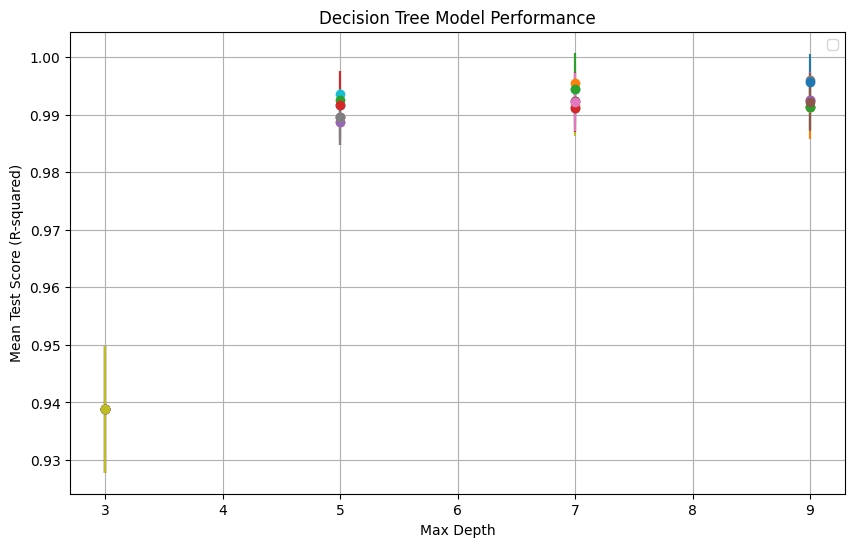

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define the decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=folds, scoring='r2', n_jobs=CPUS-1)
grid_search.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the mean test scores and standard deviations
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# Plotting mean test scores against hyperparameters
plt.figure(figsize=(10, 6))
for mean_score, std_score, param in zip(mean_scores, std_scores, params):
    plt.errorbar(param['max_depth'], mean_score, yerr=std_score, fmt='o')

plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (R-squared)')
plt.title('Decision Tree Model Performance')
plt.legend()
plt.grid(True)
plt.show()
